# Розпізнавання об'єктів на зображеннях з набору даних CIFAR-10

## Prapare import / variable

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
# from keras import regularizers
# from keras.preprocessing import image

import os
# %matplotlib inline

In [57]:
# Розмір міні-вибірки
batch_size = 16
# Кількість епох для навчання
epochs = 30
# Розмір зображеннь
img_width, img_height = 150, 150
img_size = (img_width, img_height)
# Кількість каналів в зображенні
img_channels = 3
Image_rgb_size = (img_width, img_height, img_channels)

# Кількість класів зображень
nb_classes = 2
# Назви класів
classes = ['кіт', 'собака']

imgs downloaded from: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [58]:
# Частина набору даних для тестування
test_data_portion = 0.15
# Частина набору даних для перевірки
val_data_portion = 0.15

nb_images = 12500

nb_train_samples = nb_images * 2 * (1 - test_data_portion - val_data_portion)
nb_test_samples = nb_val_samples = nb_images * 2 * val_data_portion
nb_train_samples, nb_val_samples, nb_test_samples

# Каталог з набором даних
data_dir = 'PetImages'

# Каталог з даними для навчання
train_dir = 'train'
# Каталог з даними для перевірки
val_dir = 'val'
# Каталог з даними длятестування
test_dir = 'test'

## Prapare data

### Create folder

In [59]:
import shutil

def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name,"cats"))
    os.makedirs(os.path.join(dir_name,"dogs"))

In [60]:
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

### Find and remove corrupted image

In [62]:
import os
from PIL import Image
count = 0
dir_path1 = os.path.join(data_dir, "Cat")
dir_path2 = os.path.join(data_dir, "Dog")
for mydir in dir_path1,dir_path2:
    for filename in os.listdir(mydir):
        if filename.endswith('.jpg'):
            try:
                img = Image.open(os.path.join(mydir, filename))
                img.verify()
                img.close()
            except(IOError, SyntaxError)as e:
                print('Bad file to delete :  '+mydir+"\\"+filename)
                count = count+1
                os.remove(os.path.join(mydir, filename))
print(count)


Bad file to delete :  666.jpg
1


c:\Users\Kolyanys\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


### Copy to folder

In [63]:
import shutil

def copy_images(start_index, end_index, source_dir, dest_dir):
    for i in range(start_index, end_index):
        source_path = os.path.join(source_dir, "Cat", str(i) + ".jpg")
        if os.path.exists(source_path):
            shutil.copy2(
                source_path,
                os.path.join(dest_dir, "cats")
            )
        source_path = os.path.join(source_dir, "Dog", str(i) + ".jpg")
        if os.path.exists(source_path):
            shutil.copy2(
                source_path,
                os.path.join(dest_dir, "dogs")
            )

In [64]:
start_val_data_idx = int(nb_images * (1 - val_data_portion - test_data_portion))
start_test_data_idx = int(nb_images * (1 - test_data_portion))
start_val_data_idx, start_test_data_idx

(8750, 10625)

In [65]:
copy_images(0, start_val_data_idx, data_dir, train_dir)
copy_images(start_val_data_idx, start_test_data_idx, data_dir, val_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

## Створюємо нейронну мережу

### Create model

In [16]:
# Створюємо послідовну модель
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=Image_rgb_size))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

### DataGenerator

In [18]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 25000 images belonging to 2 classes.
Found 17499 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3749 images belonging to 2 classes.


### Навчаємо нейрону мережу

In [19]:
# history = model.fit(
#     fully_generator,
#     epochs = epochs,
#     )

history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data=val_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_val_samples//batch_size)

Epoch 1/30
1093/1093 [==============================] - 57s 48ms/step - loss: 0.6683 - accuracy: 0.5705 - val_loss: 0.6124 - val_accuracy: 0.6699
Epoch 2/30
1093/1093 [==============================] - 35s 32ms/step - loss: 0.5826 - accuracy: 0.6902 - val_loss: 0.5448 - val_accuracy: 0.7220
Epoch 3/30
1093/1093 [==============================] - 35s 32ms/step - loss: 0.5374 - accuracy: 0.7301 - val_loss: 0.5421 - val_accuracy: 0.7444
Epoch 4/30
1093/1093 [==============================] - 36s 33ms/step - loss: 0.5051 - accuracy: 0.7552 - val_loss: 0.4883 - val_accuracy: 0.7676
Epoch 5/30
1093/1093 [==============================] - 35s 32ms/step - loss: 0.4768 - accuracy: 0.7709 - val_loss: 0.4637 - val_accuracy: 0.7775
Epoch 6/30
1093/1093 [==============================] - 35s 32ms/step - loss: 0.4566 - accuracy: 0.7887 - val_loss: 0.4503 - val_accuracy: 0.7778
Epoch 7/30
1093/1093 [==============================] - 35s 32ms/step - loss: 0.4310 - accuracy: 0.8042 - val_loss: 0.4171 -

## Оцінюємо якість  навчання мережі

In [20]:
# Оцінюємо якість навчання моделі на тестових даних 
scores = model.evaluate(test_generator)
print("Точність роботи на тестових даних: %.2f%%" % (scores[1]*100))

235/235 [==============================] - 10s 41ms/step - loss: 0.4132 - accuracy: 0.8613
Точність роботи на тестових даних: 86.13%


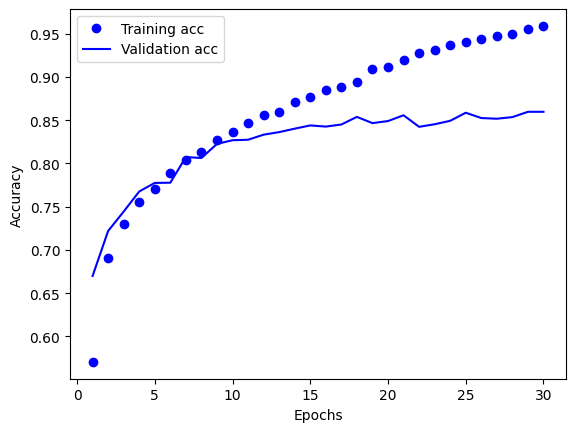

In [21]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Зберігаємо навчену нейрону мережу

In [22]:
model.save("Recognition_lab7.h5")

In [ ]:
# google.colab.files.download("Recognition_lab7.h5")

## Завантажуємо попередньо навчену нейронну мережу 


Завантажуємо файл з навченою моделлю 

In [ ]:
#!wget https://github.com/Kolyanuss/Lab_Univer/blob/master/Lab_4k_1sem/Recognise/lab7/Recognition_lab7.h5
# f = google.colab.files.upload()

Завантажуємо модель в пам'ять 

In [ ]:
from keras.models import load_model
model = load_model('Recognition_lab7.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 8, 8, 256)        

## Розпізнаємо свої зображення

In [ ]:
# files.upload()

**Дивимось завантажений малюнок**

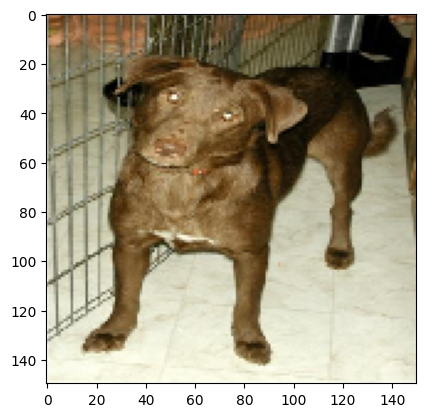

In [53]:
from keras import utils
img_path = 'PetImages\Dog\\1.jpg'
img = utils.load_img(img_path, target_size=img_size)
plt.imshow(img)
plt.show()

**Перетворюємо малюнок в масив для розпізнавання**

In [55]:
x = utils.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)
print(prediction)
prediction = round(prediction[0][0])
print(classes[prediction])

1/1 [==============================] - 0s 23ms/step
[[0.9999651]]
собака
